In [2]:
%pip install yfinance arch statsmodels pandas numpy matplotlib seaborn scikit-learn

  Using cached arch-7.2.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached arch-7.2.0-cp313-cp313-win_amd64.whl (925 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

tickers = ["^GSPC", "^N225", "^FTSE"]  # S&P 500, Nikkei 225, FTSE 100
data = yf.download(tickers, start="2010-01-01", end="2024-01-01")["Close"]
data.columns = ["SP500", "Nikkei", "FTSE"]

data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


,SP500,Nikkei,FTSE
Date,,,
2010-01-04,5500.299805,1132.989990,10654.790039
2010-01-05,5522.500000,1136.520020,10681.830078
2010-01-06,5530.000000,1137.140015,10731.450195
2010-01-07,5526.700195,1141.689941,10681.660156
2010-01-08,5534.200195,1144.979980,10798.320312


In [5]:
monthly_data = data.resample("M").mean()
monthly_data.head()

C:\Users\azizb\AppData\Local\Temp\ipykernel_104984\4238368151.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample("M").mean()


,SP500,Nikkei,FTSE
Date,,,
2010-01-31,5411.645020,1123.581582,10661.623201
2010-02-28,5231.925000,1089.159989,10175.129009
2010-03-31,5621.030465,1152.048690,10671.490456
2010-04-30,5720.744995,1197.316185,11139.770043
2010-05-31,5222.873715,1125.062006,10103.978299


In [6]:
returns = pd.DataFrame()
returns["SP500_Return"] = np.log(data["SP500"] / data["SP500"].shift(1))
returns["Nikkei_Return"] = np.log(data["Nikkei"] / data["Nikkei"].shift(1))
returns["FTSE_Return"] = np.log(data["FTSE"] / data["FTSE"].shift(1))

returns = returns.dropna()

In [7]:
def adf_test(series, title):
    result = adfuller(series)
    print(f'ADF Test for {title}:')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

adf_test(returns["SP500_Return"], "S&P 500 Returns")
adf_test(returns["Nikkei_Return"], "Nikkei Returns")
adf_test(returns["FTSE_Return"], "FTSE Returns")

ADF Test for S&P 500 Returns:
Test Statistic: -21.908714132213888
p-value: 0.0
Critical Values:
   1%: -3.432566387909864
   5%: -2.862519254448958
   10%: -2.567291283859137
ADF Test for Nikkei Returns:
Test Statistic: -14.198777180889898
p-value: 1.8030243675720691e-26
Critical Values:
   1%: -3.4325769549719443
   5%: -2.862523921490829
   10%: -2.5672937685495976
ADF Test for FTSE Returns:
Test Statistic: -28.79475668603802
p-value: 0.0
Critical Values:
   1%: -3.432563387143659
   5%: -2.8625179291294662
   10%: -2.5672905782716513


All returns series (S&P 500, Nikkei, FTSE) are stationary  (p-values ≈ 0 < 0.01).  
Suitable for modeling with ARIMA/GARCH/VAR.

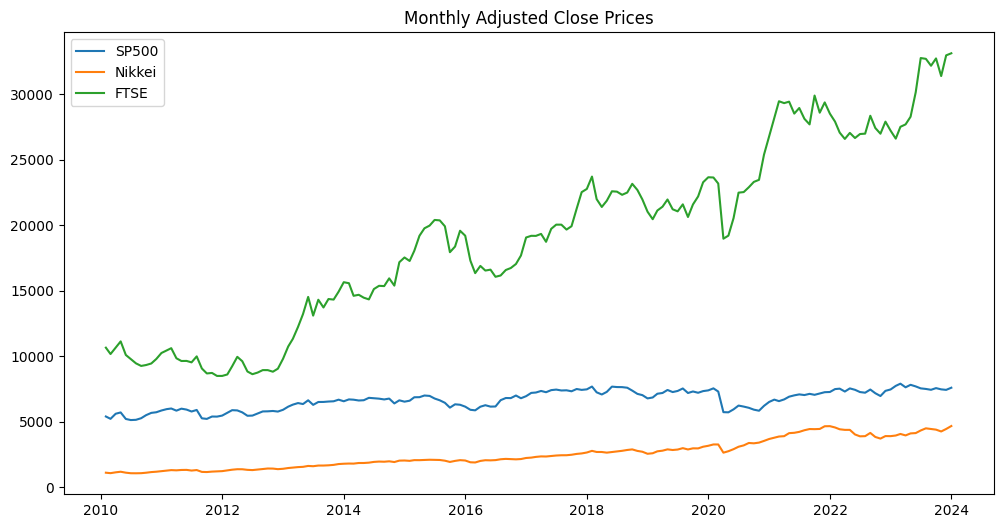

In [8]:
plt.figure(figsize=(12, 6))
for col in monthly_data.columns:
    plt.plot(monthly_data[col], label=col)
plt.title("Monthly Adjusted Close Prices")
plt.legend()
plt.savefig("price_trends.png")
plt.show()

Key Observations :  
FTSE 100  shows the sharpest increase post-2020 (COVID recovery).  
Nikkei 225  grows steadily but remains below pre-2020 levels.  
S&P 500  fluctuates but follows an upward trend.

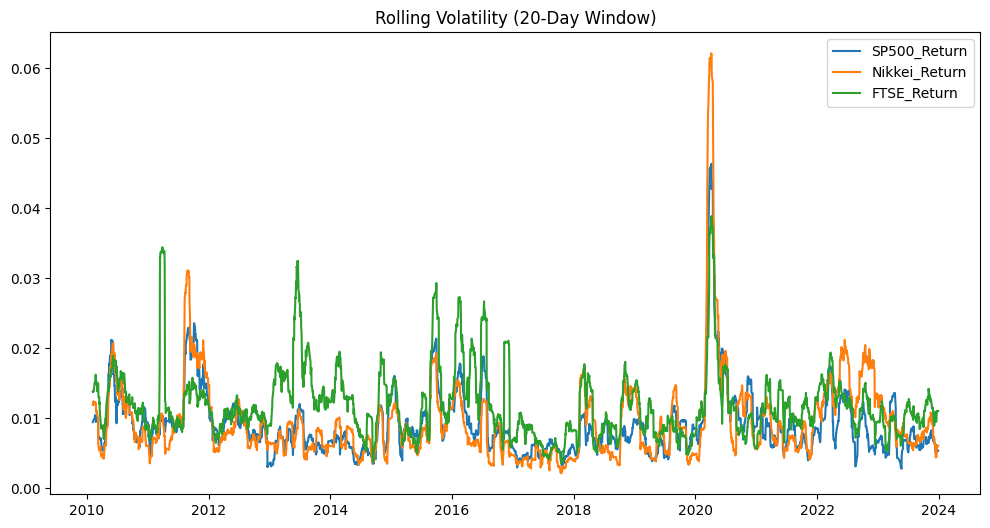

In [9]:
rolling_vol = returns.rolling(window=20).std()

plt.figure(figsize=(12, 6))
for col in rolling_vol.columns:
    plt.plot(rolling_vol[col], label=col)
plt.title("Rolling Volatility (20-Day Window)")
plt.legend()
plt.savefig("volatility_clustering.png")
plt.show()

Major Spike in 2020 :  
    COVID-19 Market Crash  caused extreme volatility across all indices.  
    FTSE 100  had the highest volatility during this period.
     
GARCH Model Validation :  
    Conditional volatility plot confirms clustering (peaks in 2020).
         
     

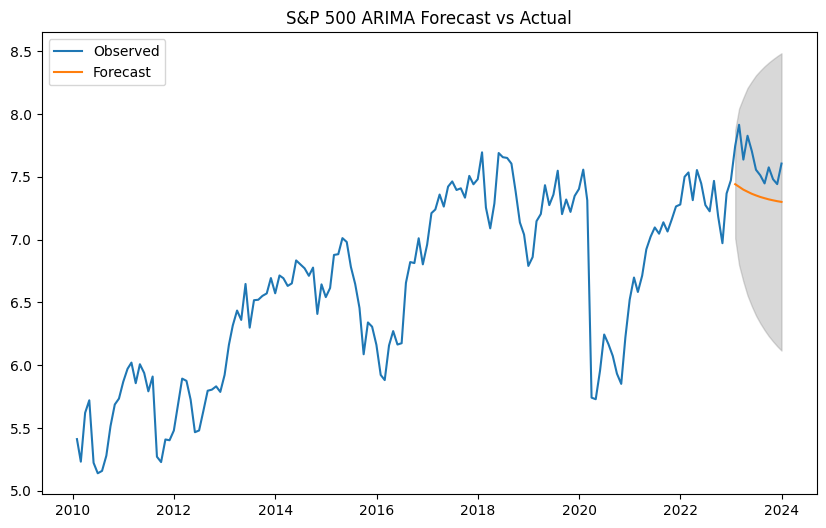

ARIMA RMSE (S&P 500): 0.2885


In [27]:
train = monthly_data.iloc[:-12] 
test = monthly_data.iloc[-12:]   

train_rescaled = train["SP500"] / 1000
test_rescaled = test["SP500"] / 1000
full_rescaled = monthly_data["SP500"]/1000

model = SARIMAX(train_rescaled, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)
forecast = results.get_forecast(steps=12)
pred_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(full_rescaled, label="Observed")
plt.plot(forecast.predicted_mean, label="Forecast")
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="gray", alpha=0.3)
plt.legend()
plt.title("S&P 500 ARIMA Forecast vs Actual")
plt.savefig("arima_forecast_sp500.png")
plt.show()

rmse = np.sqrt(mean_squared_error(test_rescaled, forecast.predicted_mean))
print(f"ARIMA RMSE (S&P 500): {rmse:.4f}")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:           SP500_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10622.9
Distribution:                  Normal   AIC:                           21253.8
Method:            Maximum Likelihood   BIC:                           21277.8
                                        No. Observations:                 2961
Date:                Fri, May 02 2025   Df Residuals:                     2960
Time:                        04:30:12   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3520      0.146      2.416  1.568e-02 [6.648e-0

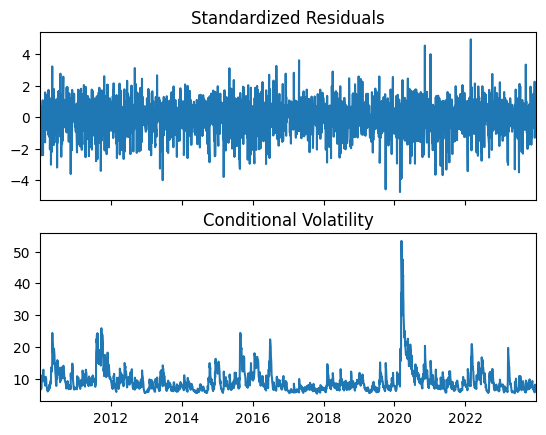

In [31]:
am = arch_model(returns["SP500_Return"]*1000, vol="Garch", p=1, q=1)
res = am.fit(disp="off")
print(res.summary())

res.plot()
plt.savefig("garch_volatility.png")
plt.show()

In [40]:
model_nikkei = SARIMAX(train["Nikkei"]/1000, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
results_nikkei = model_nikkei.fit(disp=False)
forecast_nikkei = results_nikkei.get_forecast(steps=12)

model_ftse = SARIMAX(train["FTSE"]/1000, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
results_ftse = model_ftse.fit(disp=False)
forecast_ftse = results_ftse.get_forecast(steps=12)

rmse_nikkei = np.sqrt(mean_squared_error(test["Nikkei"]/1000, forecast_nikkei.predicted_mean))
rmse_ftse = np.sqrt(mean_squared_error(test["FTSE"]/1000, forecast_ftse.predicted_mean))
print(f"ARIMA RMSE (Nikkei): {rmse_nikkei:.4f}")
print(f"ARIMA RMSE (FTSE): {rmse_ftse:.4f}")

rmse_df = pd.DataFrame({
    "Index": ["S&P 500", "Nikkei", "FTSE"],
    "RMSE": [rmse, rmse_nikkei, rmse_ftse]
})
print(rmse_df)

ARIMA RMSE (Nikkei): 0.4882
ARIMA RMSE (FTSE): 4.2146
     Index      RMSE
0  S&P 500  0.288479
1   Nikkei  0.488249
2     FTSE  4.214614


c:\Users\azizb\Desktop\class\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
